# Fiber Learning Model Demo

This notebook demonstrates fiber learning with generative models on small FIFs trained on EMNIST.<br>
First we train a subject model from which we want to learn the fibers from.<br>
Next we train a dimension-reducing VAE that should be lossless and provide a more dense latent space in which the fiber learning model is operating.<br>
Lastly we train the fiber learning model on the resulting representations of the subject model in the latent space of the VAE.

In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import yaml
import lightning_trainable
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
from pathlib import Path
matplotlib.rcParams.update({'font.size': 18})
import gc         # garbage collect library
import shutil
from scipy.special import kl_div
import h5py

In [2]:
save = False
plot_dir = "demo"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

In [3]:
def plot_images_28(data, title, model, n_rows=2, n_columns=9, save=False, plot_dir="demo"):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_columns):
            axes[i][j].imshow(data[i*n_columns + j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle(title)
    plt.show()
    if save:
        plt.savefig(f"plots/{plot_dir}/{model}/{title}.png", bbox_inches='tight')

## Evaluate fiber-learning model

In [4]:
def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense(x):
    return 0.6 * normal(x, 0.7, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.1, 0.02)

In [5]:
def compute_Wasserstein(d1,d2):
    d1 = d1.sort().values.cpu()
    d2 = d2.sort().values.cpu()
    distance = (d1-d2)
    return distance.abs().mean()

In [27]:
#If you want to load a trained model
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/C_f3f_01_ndet", version=0, epoch="last")
model = fff.fiber_model.FiberModel.load_from_checkpoint(checkpoint).eval()

(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
cond_dim:  48
output_dim:  3


In [28]:
subject_model = model.subject_model.model

In [29]:
torch.set_grad_enabled(False)

In [10]:
def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    # x_c = (1-x) c + x * ((c+0.5)%1)
    #--> x = (x_c-c)/((c+0.5)%1 - c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    #return torch.abs(x_dc)[:,2,:,:]
    #return torch.mean(x_dc.abs(),1)
    return x_dc.abs(), c

In [12]:
with h5py.File('/export/data/wjoran/FFF/data/cc_mnist/data.h5', 'r') as f:
    #Xtr = torch.from_numpy(f['train_images'][:])
    #ztr = torch.from_numpy(f['train_z'][:])
    #jtr = torch.from_numpy(f['train_jac'][:])
    Xt = torch.from_numpy(f['test_images'][:])
    #ct = torch.from_numpy(f['test_z'][:])
    #jt = torch.from_numpy(f['test_jac'][:])

In [13]:
test_set = torch.utils.data.TensorDataset(Xt)

In [30]:
@torch.no_grad()
def evaluate_model(model2plt):
    N=None
    batch_size = 256
    n_rows=2
    device = model2plt.device
    fiber_samples = []
    data_samples = []
    reconstructions = []
    
    #dataloader = torch.utils.data.DataLoader(model2plt.test_data, batch_size=batch_size, shuffle=False)
    dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    print("sampling...")
    for i, batch in enumerate(dataloader):
        #with h5py.File('notebooks/Fiber_Learning/sanders_results_10.h5', 'r') as f:
        #    z_samples = torch.from_numpy(f['test_z_samples'][:])
        batch = batch[:1]
        batch[0] = batch[0].to(device)
        batch.append(model2plt.subject_model.encode(batch[0], torch.empty(batch[0].shape[0], device=device)))
        test_conditioned = model2plt.apply_conditions(batch)
        test_c = test_conditioned.condition
        test_samples = test_conditioned.x0.to(device)
        test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
    
        #enc = model2plt.encode_lossless(test_samples[:N],test_c[:N].to(device), mu_var=False)
        #x_sampled = model2plt.decode_lossless(enc[:N],test_c[:N].to(device))
        #x_sampled = model2plt.decode_lossless(z_samples.to(device),test_c[:N].to(device))
        #plot_images_28((x_sampled.reshape(-1,3,28,28)-test_samples[:N].reshape(-1,3,28,28)).abs(),"Residuals","",n_rows=n_rows)
        #x_sampled = model2plt.sample((test_samples[:N].shape[0],),test_c[0].unsqueeze(0).repeat(N,1).to(device))
        x_sampled = model2plt.sample((test_samples[:N].shape[0],),test_c[:N].to(device))
        #x_sampled = test_samples[:N]
        
        x_dc = torch.mean(Decolorize(x_sampled)[0],1)
        c_sm = torch.empty((test_c.shape[0], 0), device=test_c.device)[:N]
        conditioned = subject_model.apply_conditions((x_dc,))
        c_sm = conditioned.condition
        x_sm = conditioned.x0
        xc = subject_model.encode(x_sm.to(subject_model.device), c_sm.to(subject_model.device))
        #print(torch.abs(xc.cpu()-test_c).mean(-1))
        #print(torch.abs(test_c[1:]-test_c[:-1]).mean(-1))
        reconstructions.append(subject_model.decode(test_c[:N].to(subject_model.device), c_sm.to(subject_model.device)).cpu())
        reconstructions1 = subject_model.decode(xc.to(subject_model.device), c_sm.to(subject_model.device)).cpu()
        fiber_samples.append(x_sampled.cpu())
        data_samples.append(test_samples.cpu())
        #xc = xc.detach().cpu()
        if i==0:
            plot_images_28(data_samples[-1],"Test data","",n_rows=n_rows)
            plot_images_28(fiber_samples[-1],"Samples","",n_rows=n_rows)
            plot_images_28(x_dc,"Samples decolored","",n_rows=n_rows)
            plot_images_28(reconstructions[-1],"Reconstructed conditions","",n_rows=n_rows)
            plot_images_28(reconstructions1,"Reconstructed decolored samples","",n_rows=n_rows)
            plot_images_28((reconstructions[-1].reshape(-1,28,28)-x_dc.cpu().reshape(-1,28,28)).abs(),"Residuals","",n_rows=n_rows)

    fiber_samples = torch.cat(fiber_samples,0)
    data_samples = torch.cat(data_samples,0)
    reconstructions = torch.cat(reconstructions,0)
    
    print(data_samples.shape)
    
    
    """
    latent_dim = xc[0].shape[0]
    residual = torch.sum((xc-test_c[:])**2, dim=1)/latent_dim
    print(x_sampled[residual<2].shape[0])
    plot_images_28(x_sampled[residual<2],"","")
    plot_images_28(x_dc[residual<2],"","")
    delta_coarse = torch.sqrt(residual)

    medians.append(torch.median(delta_coarse).numpy().item())
    means.append(torch.mean(delta_coarse).numpy().item())
    #print("median fiber deviation on test set: ", torch.median(delta_coarse))
    #print("mean fiber deviation on test set: ", torch.mean(delta_coarse))
    """
    return fiber_samples, data_samples, reconstructions

sampling...


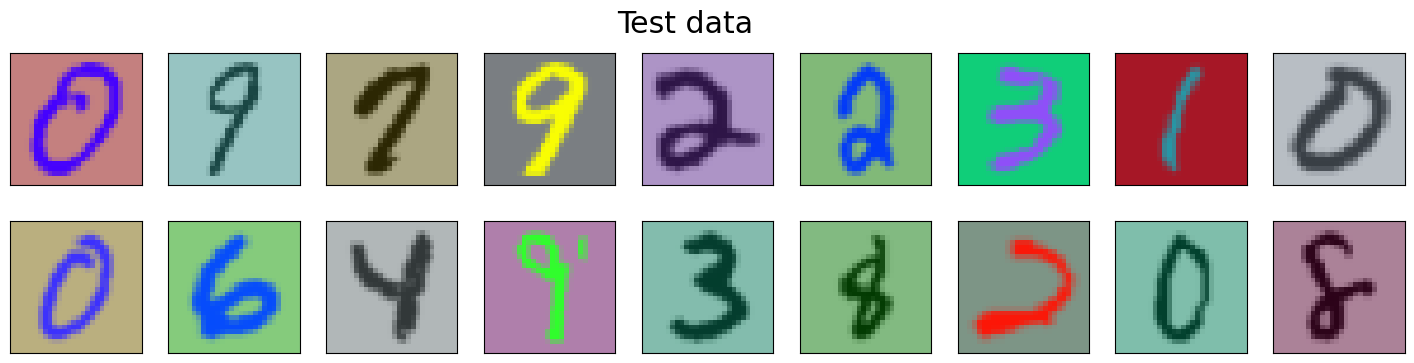

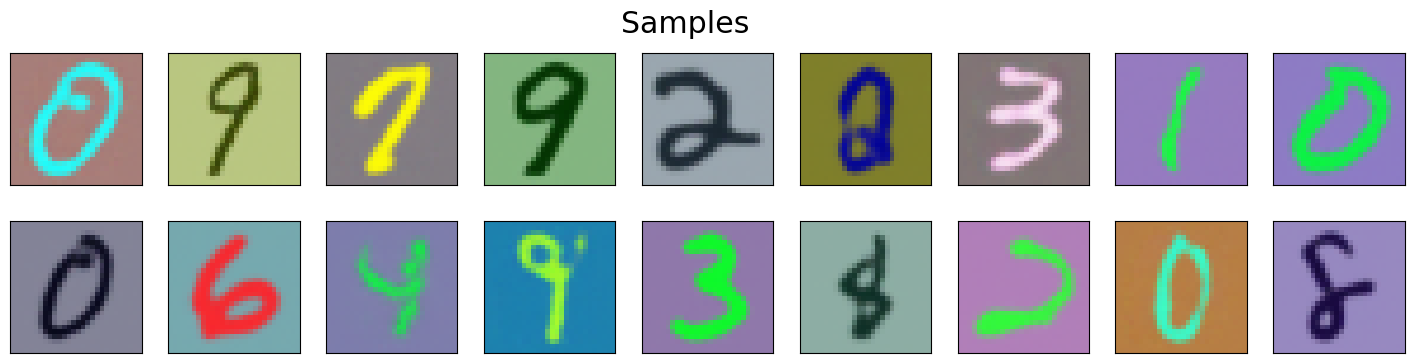

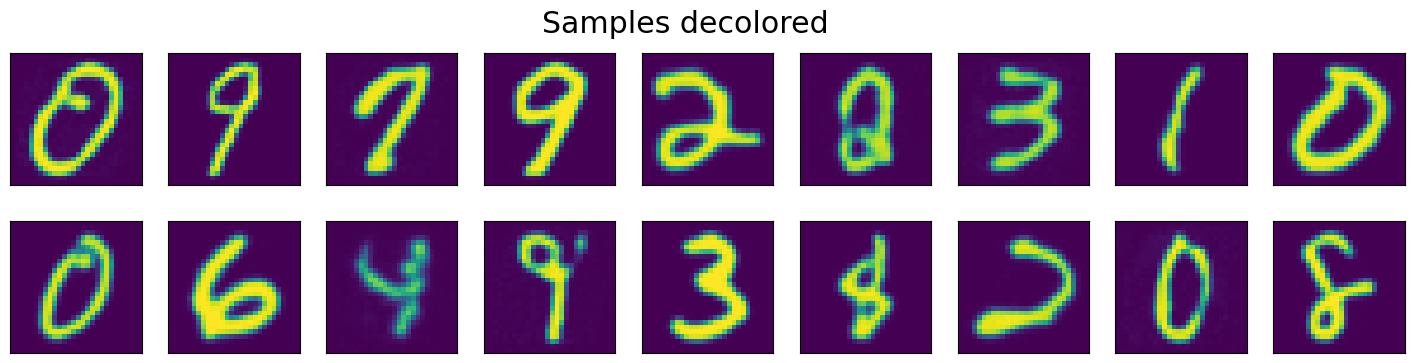

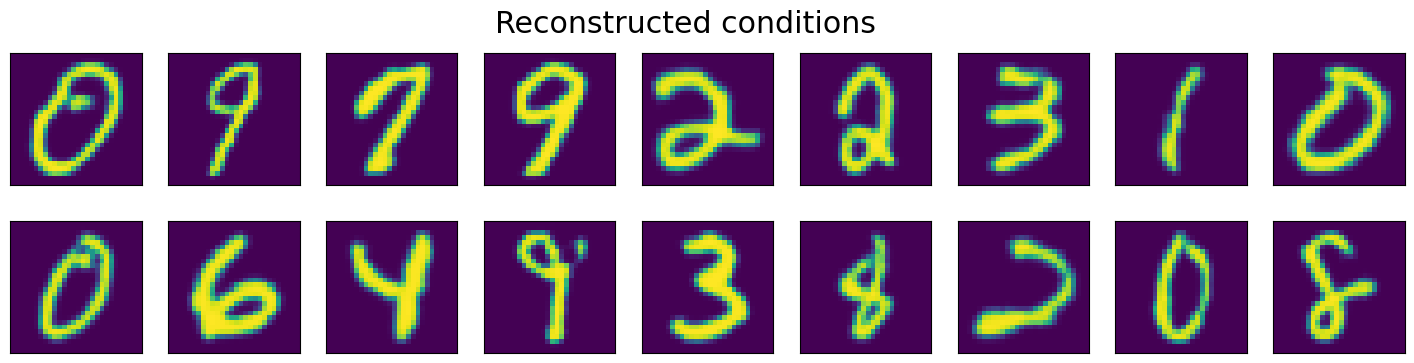

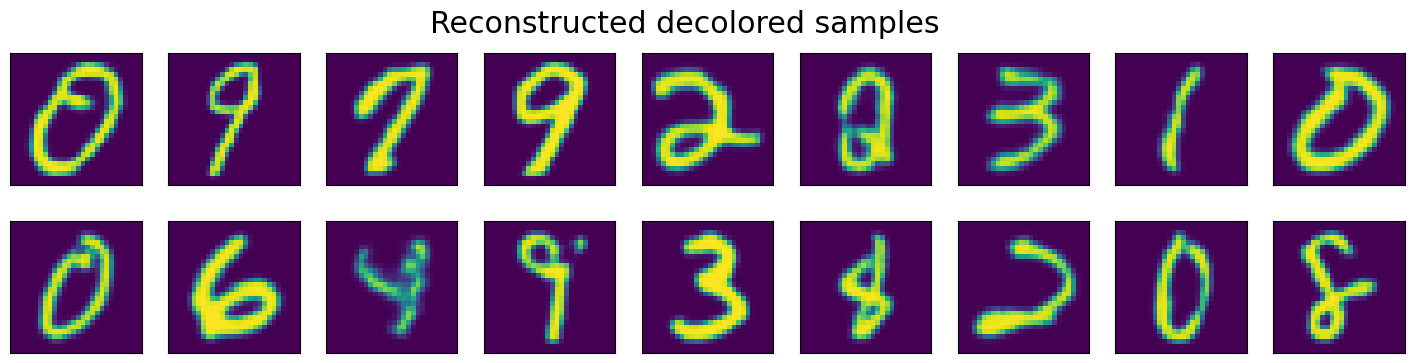

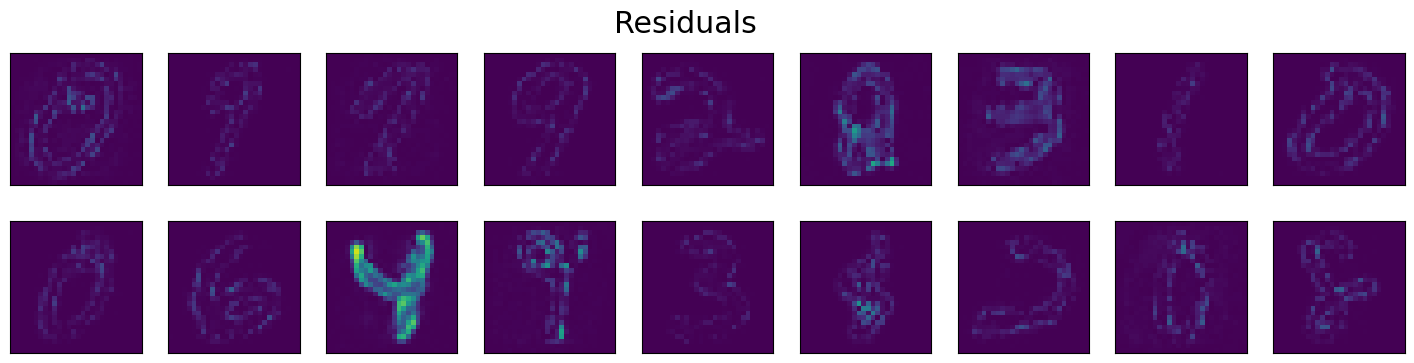

torch.Size([40000, 3, 28, 28])


In [31]:
samples, test_samples, rec = evaluate_model(model)

KL-divergence between true and sample distribution:
red:  21.379356830628648
green:  22.9795807415038
blue:  18.35743935899322


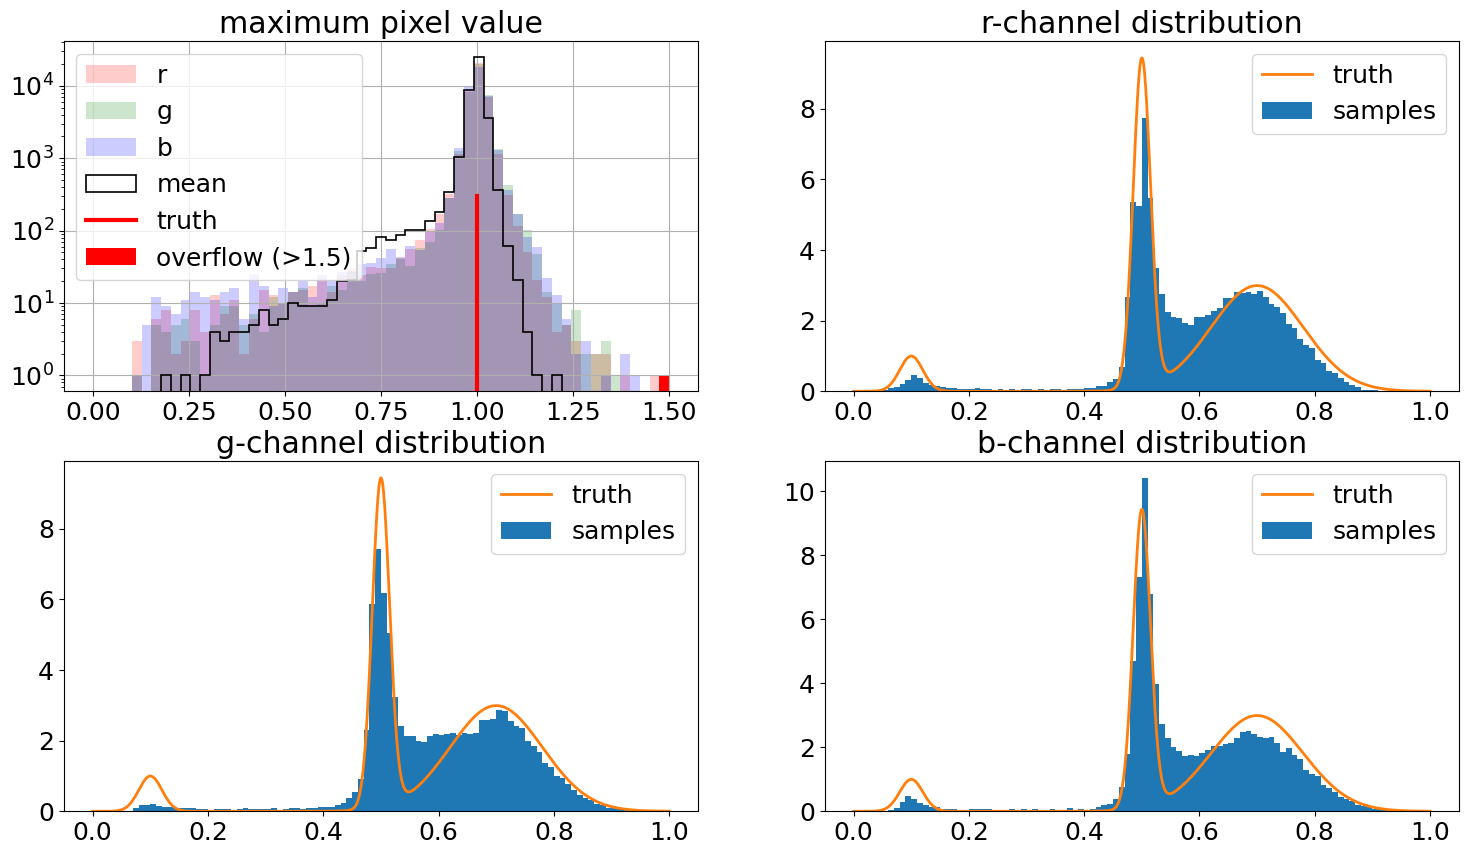

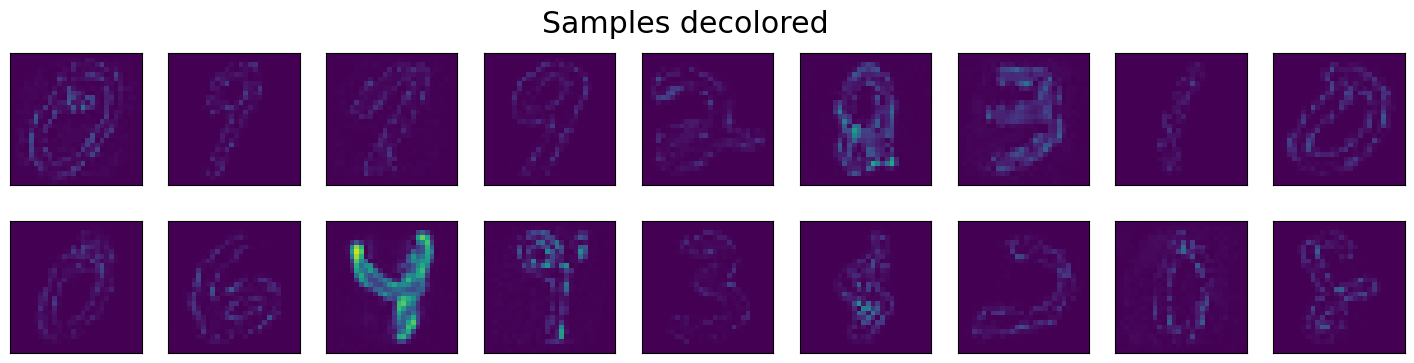

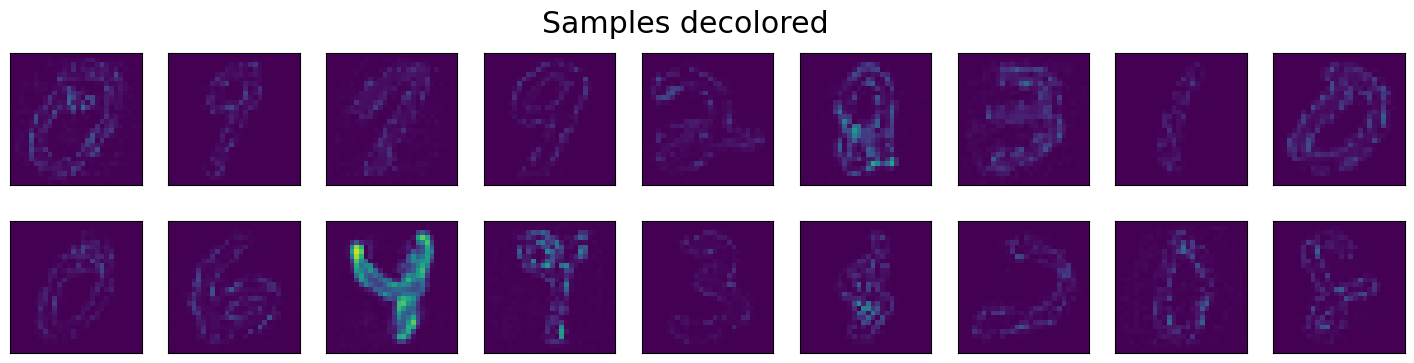

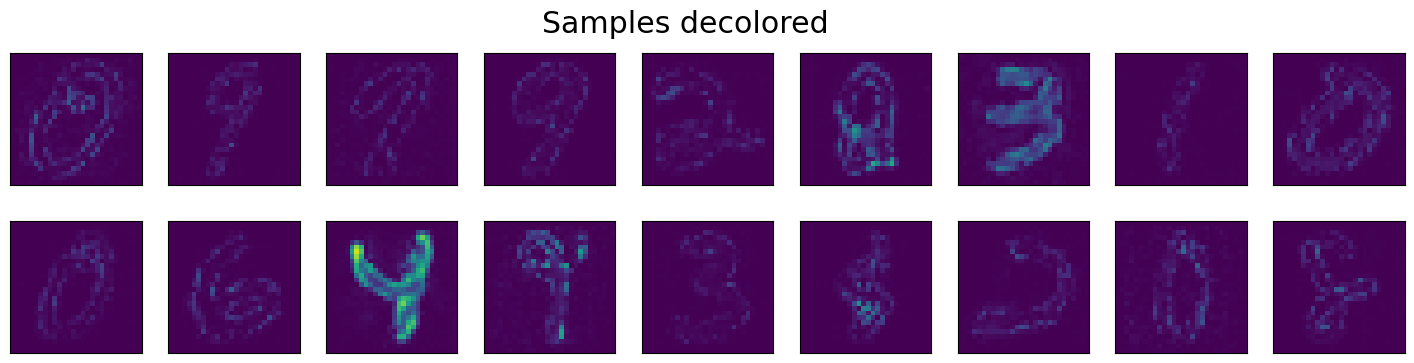

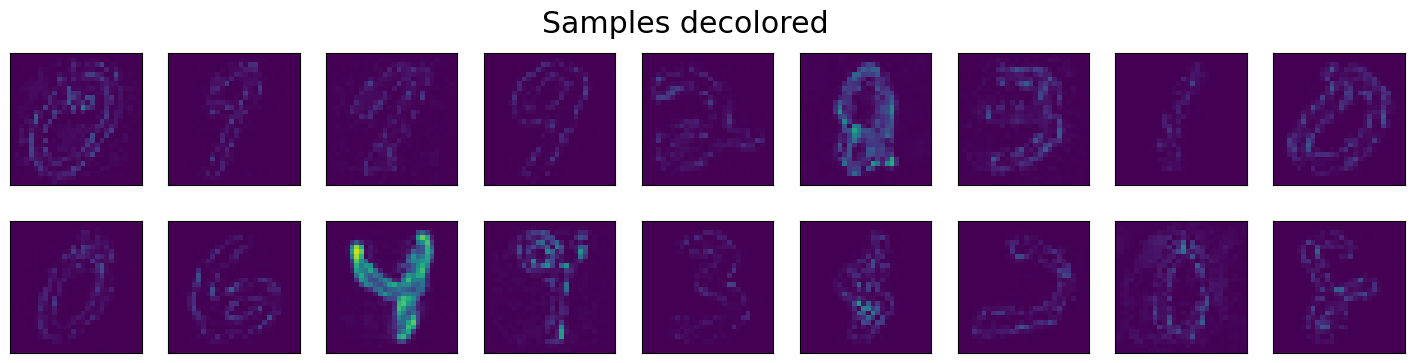

In [32]:
x_dc, c = Decolorize(samples)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes[0,0].set_title(r"maximum pixel value")
max_bin = 1.5
#axes[0,0].hist(torch.max(torch.mean(x_dc,1).reshape(-1,28*28),-1)[0].cpu(),bins=60, alpha=0.5, label="mean")
bins = np.linspace(0, max_bin, 60)
regular_bins = bins[:-1]  # Bins from -3 to 3

# Calculate how many data points are above 3 (overflow bin)
hist1 = torch.max(x_dc[:,0,:,:].reshape(-1,28*28),-1)[0].cpu()
num_overflow = len(hist1[hist1 > max_bin])
hist2 = torch.max(x_dc[:,1,:,:].reshape(-1,28*28),-1)[0].cpu()
num_overflow += len(hist2[hist2 > max_bin])
hist3 = torch.max(x_dc[:,2,:,:].reshape(-1,28*28),-1)[0].cpu()
num_overflow += len(hist3[hist3 > max_bin])
hist4 = torch.max(x_dc.mean(1).reshape(-1,28*28),-1)[0].cpu()
num_overflow += len(hist4[hist4 > max_bin])

last_bin_edge = regular_bins[-1]  # The end of the last regular bin (which is at 3)
overflow_position = [last_bin_edge + (bins[1] - bins[0]) / 2]  # Position for the overflow bar

axes[0,0].hist(hist1, bins=regular_bins, label="r", color="r",alpha=0.2, linewidth=0.7,histtype='stepfilled')
axes[0,0].bar(overflow_position, num_overflow, width=bins[1] - bins[0], color='red', label=f'overflow (>{max_bin})')
axes[0,0].hist(hist2, bins=regular_bins, label="g", color="g",alpha=0.2, linewidth=0.7,histtype='stepfilled')
axes[0,0].hist(hist3, bins=regular_bins, label="b", color="b",alpha=0.2, linewidth=0.7,histtype='stepfilled')
axes[0,0].hist(hist4, bins=regular_bins, label="mean", color="black",histtype='step', linewidth=1.2)
axes[0,0].plot((1,1),(0,300),c="r", linewidth=3, label="truth")
axes[0,0].grid(True)
axes[0,0].legend()
axes[0,0].set_yscale("log")

axes[0,1].set_title(r"r-channel distribution")
H, bins = np.histogram(c[:,0].cpu(), bins=100, range=[0, 1],density=True)
print("KL-divergence between true and sample distribution:")
print("red: ", np.sum(kl_div(H, gaussian_mix_dense(bins[:-1]+(bins[1]-bins[0])/2))))
axes[0,1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
x = np.linspace(0,1,1000)
axes[0,1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[0,1].legend()

axes[1,0].set_title(r"g-channel distribution")
H, bins = np.histogram(c[:,1].cpu(), bins=100, range=[0, 1],density=True)
print("green: ", np.sum(kl_div(H, gaussian_mix_dense(bins[:-1]+(bins[1]-bins[0])/2))))
axes[1,0].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[1,0].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[1,0].legend()

axes[1,1].set_title(r"b-channel distribution")
H, bins = np.histogram(c[:,2].cpu(), bins=100, range=[0, 1],density=True)
print("blue: ", np.sum(kl_div(H, gaussian_mix_dense(bins[:-1]+(bins[1]-bins[0])/2))))
axes[1,1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[1,1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[1,1].legend()
plot_images_28(torch.abs(torch.mean(x_dc,1)-rec.reshape(-1,28,28)),"Samples decolored","",n_rows=2)
plot_images_28(torch.abs(x_dc[:,0,:,:]-rec.reshape(-1,28,28)),"Samples decolored","",n_rows=2)
plot_images_28(torch.abs(x_dc[:,1,:,:]-rec.reshape(-1,28,28)),"Samples decolored","",n_rows=2)
plot_images_28(torch.abs(x_dc[:,2,:,:]-rec.reshape(-1,28,28)),"Samples decolored","",n_rows=2)

In [11]:
from functools import partial
def relaxed_fiber_energy(x, h, subject_model, beta=1):
    c_0 = torch.empty_like(x, device=x.device)
    h_hat = subject_model.encode(x, c_0).cpu()
    return torch.mean(beta*(h_hat - h)**2, dim=-1)

def get_energy_fnc(h, subject_model, beta=1):
    return partial(relaxed_fiber_energy, h=h, subject_model=subject_model, beta=beta)

In [12]:
from functools import partial
"""
def relaxed_c_distribution(x, subject_model, jac, epsilon=0.05):
    _, c0, _ = subject_model.encode(x, torch.empty(x.shape[0]), mu_var=True)
    sigma_h = epsilon * jac.unsqueeze(1).repeat(1, c0.shape[1]).sqrt()
    mu_h = c0
    h = torch.randn_like(c0) * sigma_h.to(c0.device) + c0
    return h

def get_c_distribution(subject_model, jac, epsilon=0.05):
    return partial(relaxed_c_distribution, subject_model=subject_model, jac=jac, epsilon=epsilon)
"""
def relaxed_c_distribution(x, subject_model, beta=100):
    _, c0, _ = subject_model.encode(x, torch.empty(x.shape[0]), mu_var=True)
    sigma_h = epsilon * jac.unsqueeze(1).repeat(1, c0.shape[1]).sqrt()
    mu_h = c0
    h = torch.randn_like(c0) * sigma_h.to(c0.device) + c0
    return h

def get_c_distribution(subject_model, jac, epsilon=0.05):
    return partial(relaxed_c_distribution, subject_model=subject_model, jac=jac, epsilon=epsilon)

In [31]:
def evaluate_model_FQ(model2plt):
    batch_size = 256
    #dataloader = torch.utils.data.DataLoader(model2plt.test_data, batch_size=batch_size, shuffle=False)
    dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    plot_fiber_quality(model2plt, model2plt.subject_model, dataloader, clip_energy=10000)

In [70]:
from math import prod
from torch.autograd.functional import jacobian
from torch.func import jacrev
from fff.utils.func import *

def log_Z(beta, dim=2):
    return np.log(beta)*dim + dim / 2 * np.log(2 * np.pi)

@torch.no_grad()
def plot_fiber_quality(fiber_model, subject_model, test_loader, epsilon_range=[0.0005, 0.05], num_epsilons=5, batch_size=512, model_name="Fiber model", color="C0", clip_energy=None, nf=True):
    fiber_model.to("cuda")
    device = fiber_model.device
    #logj_sms, log_jacs, x_data, c_data = [], [], [], []
    nlls = []
    valid_shapes = []

    print("computing FQ")
    nlls = []
    for i, epsilon in enumerate(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons)):
        nlls_epsilon = []
        print(epsilon)
        i=0
        for batch in test_loader:
            test_conditioned = fiber_model.apply_conditions(batch[:2])
            #test_c = test_conditioned.condition.to(device)
            test_samples = test_conditioned.x0.to(device).reshape(-1,3*28*28)
            Jac_sm = batch[2].reshape(-1,48,3*28*28)
            logj_sm = torch.bmm(Jac_sm, Jac_sm.permute((0,-1,-2))).logdet()/2
            c_distribution = get_c_distribution(subject_model, logj_sm, epsilon)
            c_sampled = c_distribution(test_samples)
            
            z, Jacs = compute_jacobian(test_samples, fiber_model.encode, c_sampled, chunk_size=None)
            Jacs = Jacs.squeeze()
            log_jacs_complete = torch.bmm(Jacs, Jacs.permute((0,-1,-2))).logdet()/2
            i_invalid = torch.logical_or(torch.isinf(log_jacs_complete), torch.isnan(log_jacs_complete)).cpu()
            nll = torch.mean(z**2, dim=1)/2 - log_jacs_complete/z.shape[1]
            #logj_sms.append(logj_sm[~i_invalid].cpu())
            nlls_epsilon.append(nll[~i_invalid].cpu())
            #x_data.append(test_samples[~i_invalid].cpu())
            #c_data.append(test_c[~i_invalid].cpu())
            i+=1
            if i%100==0:
                print(i)
            if i==2000:
                break
        nlls_epsilon = torch.cat(nlls_epsilon, dim=0)
        valid_shapes.append(nlls_epsilon.shape[0])
        nlls.append(nlls_epsilon.numpy())
    print(valid_shapes)

    bootstrap_mean, bootstrap_std = [], []
    for nll_epsilon in nlls:
        print(nll_epsilon[:20])
        if clip_energy is not None:
            print(f"{(nll_epsilon > clip_energy).sum(axis=0)*100/prod(nll_epsilon.shape[:])} % are clipped")
            nll_epsilon[nll_epsilon > clip_energy] = clip_energy
        bootstrap_samples = []
        for i in range(1000):
            bootstrap_idx = np.random.choice(nll_epsilon.shape[0], nll_epsilon.shape[0])
            bootstrap_samples.append(np.mean(nll_epsilon[bootstrap_idx]))
        bootstrap_samples = np.array(bootstrap_samples)
        bootstrap_mean.append(np.mean(bootstrap_samples))
        bootstrap_std.append(np.std(bootstrap_samples))
    bootstrap_mean, bootstrap_std = np.array(bootstrap_mean), np.array(bootstrap_std)
        
    nlls_mean = np.array([nll_epsilon.mean() for nll_epsilon in nlls])
    print(-nlls_mean)
    plt.plot(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - nlls_mean, color=color, label=model_name)
    
    plt.fill_between(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - bootstrap_mean - 2 * bootstrap_std, - bootstrap_mean + 2 * bootstrap_std, color=color, alpha=0.3)

    plt.scatter(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - nlls_mean, color=color, s=5)

computing FQ
tensor(0.0005)
100
200
300
400
500
600
700
800
900
tensor(0.0016)
100
200
300
400
500
600
700
800
900
tensor(0.0050)
100
200
300
400
500
600
700
800
900
tensor(0.0158)
100
200
300
400
500
600
700
800
900
tensor(0.0500)
100
200
300
400
500
600
700
800
900
[239984, 239984, 239984, 239984, 239984]
[0.7780933  1.0719794  0.4236323  0.7094665  0.90751654 0.38075364
 1.5440645  1.1078666  1.9093043  0.98465705 1.1572806  0.7847358
 1.1957382  1.3938051  1.6949582  0.6389879  0.8171759  1.2820712
 0.7484337  1.2272263 ]
0.0 % are clipped
[0.81791186 1.0773879  0.4681111  0.7109498  0.88849944 0.21580267
 1.5554318  1.1003025  1.9009619  0.9858773  1.1515508  0.78793305
 1.2067707  1.3978133  1.6740477  0.63526636 0.9376952  1.2608953
 0.7435266  1.2160385 ]
0.0 % are clipped
[0.7575794  1.0764673  0.46043876 0.7311772  0.88953835 0.1925812
 1.5471288  1.0990282  1.9186809  0.9739567  1.1634531  0.8072855
 1.2060089  1.3946472  1.6880563  0.64969456 0.8284459  1.2550888
 0.7236877

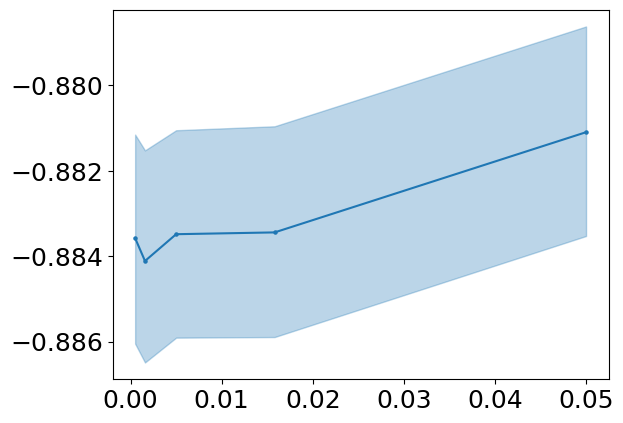

In [71]:
evaluate_model_FQ(model)